<a href="https://colab.research.google.com/github/Check-Your-Skin/checkyourskin-ml_model/blob/train-cnn-ham10000/Data%20Preparation/HAM10000_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import**

In [1]:
import os
import io
import shutil
import zipfile
import random

import pandas as pd
from glob import glob
from PIL import Image
from google.colab.patches import cv2_imshow
from concurrent.futures import ThreadPoolExecutor
import cv2

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization
from keras import metrics
from keras.metrics import Precision, Recall
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/')

In [4]:
shutil.rmtree('/content/HAM10000/ham10000_images_part_1')
shutil.rmtree('/content/HAM10000/ham10000_images_part_2')

#Data Preparation

###Check Image Size

In [5]:
width = 600
height = 450
wrong_size = 0
data = glob('/content/HAM10000/*')
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    for image in images:
      img = Image.open(image)
      w, h = img.size
      if (w != width or h != height):
        wrong_size =+ 1
        print(f'Path: {image}\nHeight: {h}\nWidth: {w}')
print(wrong_size)

0


###Resize Images





In [7]:
def resize_image(image):
  img = Image.open(image)
  width, height = img.size
  global new_height
  global new_width
  new_height = 250
  new_width  = int(new_height * width / height)
  img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
  img_name = os.path.basename(image)
  img.save(resize_dest_dir + img_name)

In [8]:
size = 128
resize_dest_dir = '/content/HAM10000/HAM10000_images/'
try:
  os.mkdir(resize_dest_dir)
except:
  pass
data = glob('/content/HAM10000/*')
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    with ThreadPoolExecutor() as executor:
      executor.map(resize_image, images)

In [5]:
resize_dest_dir = '/content/HAM10000/HAM10000_images/'
try:
  os.mkdir(resize_dest_dir)
except:
  pass
data = glob('/content/HAM10000/*')
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    for image in images:
      shutil.copy(image, resize_dest_dir)

In [7]:
print(len(glob('/content/HAM10000/HAM10000_images/*')))

10015


In [8]:
shutil.rmtree('/content/HAM10000/HAM10000_images_part_1')
shutil.rmtree('/content/HAM10000/HAM10000_images_part_2')

In [9]:
#Dictionary to match the Image_id with the Path of the Image
imgPath = {}
for x in glob(os.path.join('/content/HAM10000/HAM10000_images/*.jpg')):
    imgPath[os.path.splitext(os.path.basename(x))[0]] = x

In [10]:
#Add Resized Image data to DataFrame
file_path = '/content/HAM10000/HAM10000_metadata.csv'
df = pd.read_csv(file_path)


size = (128,128)
df['image'] = df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))

In [11]:
#Adding numerical lable for one-hot encoding
numerical_label = LabelEncoder().fit(df['dx']).transform(df['dx'])
df['label'] = numerical_label

In [12]:
x = np.asarray(df['image'].to_list())
x = x / 255
y = df['label']
y = to_categorical(y, num_classes=7)
x_train, x_sum, y_train, y_sum = train_test_split(x, y, train_size=0.7, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_sum, y_sum, test_size=0.5)

In [13]:
print('Train: ',len(x_train))
print('Test: ',len(x_test))
print('Validation: ',len(x_valid))

Train:  7010
Test:  1503
Validation:  1502


#Build Model

In [14]:
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(input_shape=(128,128,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [16]:
learning_rate = 0.0005

optimizer = Adam(learning_rate=learning_rate)

optimizer_name = 'Adam'

loss_name = 'categorical_crossentropy'

model.compile(optimizer=optimizer,
              loss=loss_name,
              metrics = ['accuracy'])

In [17]:
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=16)

Epoch 1/30
439/439 [==============================] - 15s 16ms/step - loss: 1.2729 - accuracy: 0.6126 - val_loss: 1.1816 - val_accuracy: 0.6265
Epoch 2/30
439/439 [==============================] - 5s 12ms/step - loss: 0.8705 - accuracy: 0.7041 - val_loss: 0.8309 - val_accuracy: 0.7077
Epoch 3/30
439/439 [==============================] - 5s 12ms/step - loss: 0.7869 - accuracy: 0.7248 - val_loss: 0.8749 - val_accuracy: 0.7091
Epoch 4/30
439/439 [==============================] - 5s 12ms/step - loss: 0.7361 - accuracy: 0.7378 - val_loss: 0.8879 - val_accuracy: 0.6591
Epoch 5/30
439/439 [==============================] - 5s 12ms/step - loss: 0.6861 - accuracy: 0.7586 - val_loss: 0.9067 - val_accuracy: 0.6964
Epoch 6/30
439/439 [==============================] - 5s 13ms/step - loss: 0.6439 - accuracy: 0.7653 - val_loss: 0.9560 - val_accuracy: 0.6997
Epoch 7/30
439/439 [==============================] - 5s 12ms/step - loss: 0.5912 - accuracy: 0.7890 - val_loss: 0.8103 - val_accuracy: 0.747

#Evaluation

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Accuracy: ', test_accuracy)
print('Loss: ', test_loss)

47/47 [==============================] - 1s 13ms/step - loss: 1.2076 - accuracy: 0.7418
Accuracy:  0.7418496608734131
Loss:  1.2076317071914673


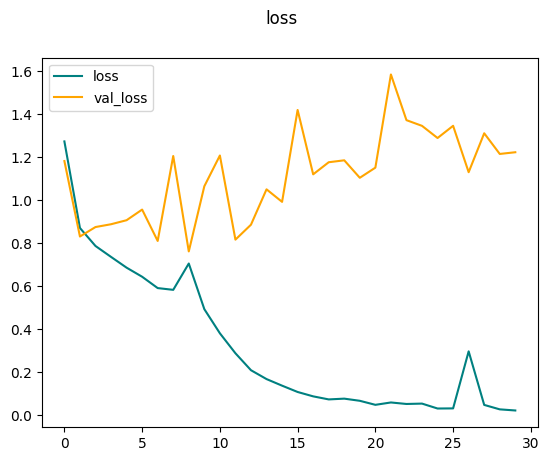

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val Loss')
fig.suptitle('Loss')
plt.legend(loc='upper left')
plt.show()

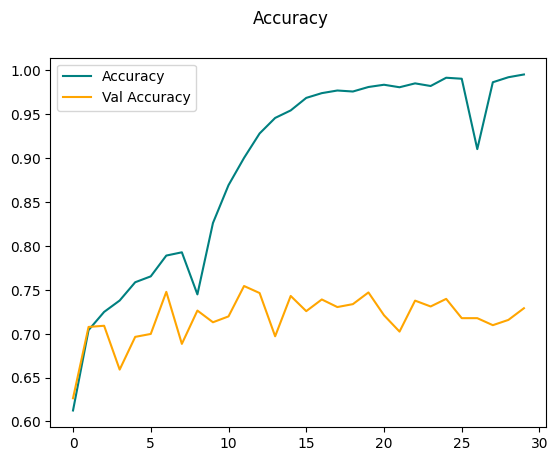

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Val Accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

#Save Model

In [20]:
model.save('/content/drive/My Drive/ML-Models/')